# Neutron spectrum calculations with the `dress` package
*Jacob Eriksson*

## Introduction
The `dress` package is a set of python modules that allow for the calculation of neutron energy spectra from the various fusion reactions. To use it you first need to import it (which of course requires that the dress directory is on your path):

In [1]:
import sys
sys.path.append('/home/jeriks/Utils/pydress')    # Change this line to reflect the location of the dress folder

import dress

## Basic usage
To start calculating spectra, we first need to create an instance of the `Reaction` class, representing the reaction under consideration:

In [2]:
reaction = dress.reactions.DDNHe3Reaction()

Then we create an instance of the `SpectrumCalculator` class, passing the reaction as an argument:

In [3]:
spec_calc = dress.SpectrumCalculator(reaction, n_samples=1e6)

Next we need to draw samples from the reactant velocity distributions. This can be done in any number of ways, as long as the end result is that the `v` attributes of each reactants are both set with `(3,N)` arrays containing `N` samples of the 3 velocity components. For instance, to simulate two mono-energetic beams colliding at right angles we could do the following:

In [4]:
N = spec_calc.n_samples

va = np.zeros((3,N))
vb = np.zeros((3,N))

va[1] = 1e6             # velocity purely in the y-direction (m/s)
vb[2] = 1e6             # velocity purely in the z-direction (m/s)

spec_calc.reactant_a.v = va
spec_calc.reactant_b.v = vb

The spectrum is now calculated with a command like this:

In [5]:
spectrum, bin_centers = spec_calc()

Custom bins can be defined by through the keyword arguments `bins` and `bin_edges` (type `help(spec_calc)` for more details).

We can now plot the calculated spectrum to see how it looks.

Text(0, 0.5, 'Spectrum (au)')

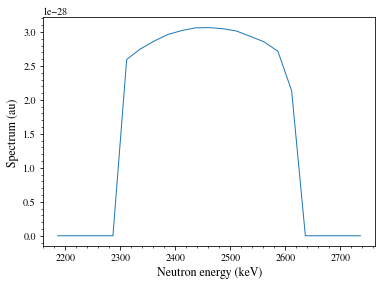

In [6]:
import matplotlib.pyplot as plt

plt.plot(bin_centers, spectrum)
plt.xlabel('Neutron energy (keV)')
plt.ylabel('Spectrum (au)')

We see that this spectrum is centered around 2.5 MeV, as expected for DD neutron emission. The broadening is due to that, by default, the calculated neutron emission is integrated over all emission angles. If we would be interested in the emission in a specific direction, this can controlled with the `u` attribute. For instance, if we want to calculate the spectrum emitted in the x-direction we would do the following:

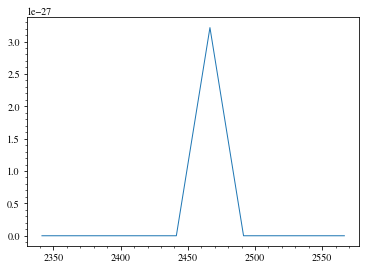

In [7]:
spec_calc.u = [1,0,0]
spectrum, bin_centers = spec_calc()

plt.plot(bin_centers, spectrum)

We see that this results in a mono-energetic neutron emission, as expected for these mono-energetic and mono-directional reactants.

## Sampling different distributions

In most cases one would like to sample more realistic distributions than the ones used above. The `spec.Reactant` class comes with four built-in options for sampling different common distributions.

* `sample_maxwellian_dist(T, pitch_range=[-1,1], v_rot=0.0)` samples a Maxwellian energy distribution with given temperature `T` (keV). The pitch (i.e. v$_\parallel$/v) is sampled uniformly between the values specified by `pitch_range` and it is possible to add a collective velocity `v_rot` to all samples (this is added to the y-component of the velocity).

* `sample_mono_dist(E0, pitch_range=[-1,1])` samples energies from a mono-energetic distribution with energy `E0` (keV), with pitch values drawn uniformly from the given range.

* `sample_E_dist(Ep, fp, pitch_range=[-1,1])` samples an arbitrary energy distribution described by the energy axis `Ep` (keV) and the distibution values `fp`. Pitch values are drawn uniformly from the given range.

* `sample_EP_dist(Ep, pitch_p, fp)` samples an arbitrary energy-pitch distribution, where `Ep` (keV) defines the energy axis, `pitch_p` defines the pitch axis and `fp`, which should have shape (Ep.size, pitch_p.size), defines the distribution.

The number of samples drawn by the methods above is determined by the `spec_calc.n_samples` attribute.

So for instance, if we would like to calculate the spectrum from a Maxwellian population that reacts with a mono-energetic population we could do like this:

Text(0, 0.5, 'Spectrum (au)')

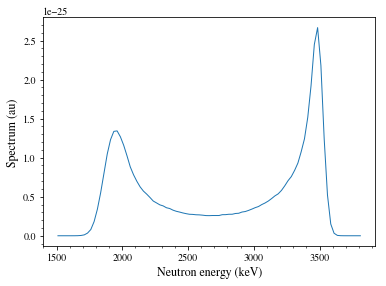

In [8]:
spec_calc.n_samples = 1e6
spec_calc.u = [0,0,1]       # Tip: try playing with the emission direction to see how this impacts the spectrum

T = 5.0       # temperature of reactant a (keV)
spec_calc.reactant_a.sample_maxwellian_dist(T)

E0 = 500.0    # beam-energy of reactant b(keV)
pitch_range = [-0.1, 0.1]
spec_calc.reactant_b.sample_mono_dist(E0, pitch_range=pitch_range)

spectrum, bin_centers = spec_calc()

plt.plot(bin_centers, spectrum)
plt.xlabel('Neutron energy (keV)')
plt.ylabel('Spectrum (au)')

If we instead would like to sample one of the reactants from some arbitrary (energy,pitch) distribution we could do like this:

Text(0, 0.5, 'v$_{\\parallel}/v$')

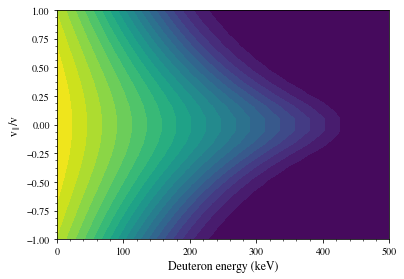

In [9]:
import numpy as np

# Create mock-up (E,p) dist
E_axis = np.linspace(0,500.0,100)    # energy axis (keV)
p_axis = np.linspace(-1.0,1.0,20)    # pitch axis

E0 = 450.0
f_E = 1 - E_axis/E0

delta_p = 3 * np.exp(-E_axis/(E0/3))
delta_p[f_E<0] = 1
f_E[f_E<0] = 0.0
f_p = np.exp(-p_axis[:,None]**2 / delta_p**2)   # use broadcasting to obtain "outer division"

f = np.transpose(f_E * f_p)

plt.contourf(E_axis, p_axis, f.T, 20)
plt.xlabel('Deuteron energy (keV)')
plt.ylabel('v$_{\parallel}/v$')

Text(0, 0.5, 'Spectrum (au)')

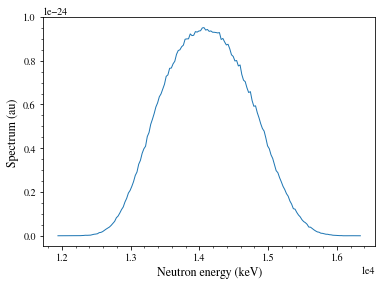

In [12]:
spec_calc.reactant_b.sample_EP_dist(E_axis, p_axis, f)
spec_calc.u1 = [0,1,1]     # Tip: try playing with the emission angle to see how this impacts the spectrum

spectrum, bin_centers = spec_calc()

plt.plot(bin_centers, spectrum)
plt.xlabel('Neutron energy (keV)')
plt.ylabel('Spectrum (au)')

## Spectrum normalization
By default, the calculated spectra are normalized such that the *sum of the spectrum histogram is equal to the reactivity $\left< \sigma v \right>$ per steradian for the reaction under consideration*. Hence, to calculate the DT thermonuclear reactivity at a given temperature we could to the following:

In [13]:
reaction = dress.reactions.DTNHe4Reaction()
spec_calc = dress.SpectrumCalculator(reaction, n_samples=1e6)

T = 10.0     # keV

spec_calc.reactant_a.sample_maxwellian_dist(T)      # deuterons
spec_calc.reactant_b.sample_maxwellian_dist(T)      # tritons

spectrum, bin_centers = spec_calc()

print('DT reactivity @ {:.1f} keV = {:.3e} m^{{3}}/s'.format(T, 4*np.pi*spectrum.sum()))

DT reactivity @ 10.0 keV = 1.145e-22 m^{3}/s


To obtain the neutron emission per unit volume, unit solid angle and unit time from two given fuel ion populations, we would then multiply the above spectrum with the fuel ion densities (and remember to divide by 2 if reactants a and b are sampled from the same distribution).

### Advanced event weighting
If more flexibility is required regarding how the samples are weighted in the calculations, it is possible to manually set the attribute `spec_calc.weights`. Each Monte Carlo reaction event contributes to the neutron sectrum histogram with a weight given by

$$
w_{tot} = w \sigma v
$$

The default is `weights = None`, which effectively means that $w = 1/n_{samples}$ in the above equation, which means that the sum of the spectrum histogram will be an estimate of $\left< \sigma v \right>$, as remarked above.